# Hands on : introduction to NN on HEP dataset

This tutorial will be focused on the classification problem in a physics example: training a neural network classifier to distinguish the Higgs boson signals from background events.

In this tutorial, we will use TensorFlow and Keras to train our neural networks (different from the first hands on tutorial which uses PyTorch), but the concept is the same, and we will be focused more on data processing, model optimization and overtraining.

Outline:
- Load data from root files
- Explore the data and weights
- Preprocess data for training
- Train a neural network
- Quantify its performance
- Tune the model and overtraining

## Import Packages

In [56]:
import os
import numpy as np # numpy is a python package for data processing
import pandas as pd # pandas is a python package for data processing
import matplotlib.pyplot as plt # matplotlib is a powerful package for plotting results
import uproot # uproot is a useful python package to read data from root files

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras as K
from keras.metrics import AUC
print("Tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from IPython.display import display, HTML
%matplotlib inline
import time
pd.set_option('display.max_columns', None) # to see all columns of df.head()

Tensorflow version: 2.12.0
Num GPUs Available:  0


## Load events

Data were created from ATLAS Open Data:

http://opendata.atlas.cern/release/2020/documentation/datasets/intro.html

The dataset we will be using contain MC simulation of the Standard Model Higgs boson production events, as well as Standard Model background, including top-quark-pair production, single-top production, production of weak bosons in association with jets (W+jets, Z+jets) and production of a pair of bosons (diboson WW, WZ, ZZ).

All the data are stored in a root file, which contains different kinematic variables of each event, the event label to indicate whether an event is a signal or background, as well as the MC event weights. We use [uproot](https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf) to read data from the root file.

In [2]:
filename=("dataWW_d1.root")
file = uproot.open(filename)

# show what is inside the root file loaded from uproot
print(file.classnames())
print(file.keys())

tree = file["tree_event"] # select the TTree inside the root file
tree.show() # show all the branches inside the TTree
dfall = tree.arrays(library="pd") # convert uproot TTree into pandas dataframe
print("============================================")
print ("File loaded with ",len(dfall), " events ")

{'tree_event;1': 'TTree'}
['tree_event;1']
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
index                | int64_t                  | AsDtype('>i8')
eventNumber          | int64_t                  | AsDtype('>i8')
label                | int64_t                  | AsDtype('>i8')
met_et               | double                   | AsDtype('>f8')
met_phi              | double                   | AsDtype('>f8')
lep_n                | int64_t                  | AsDtype('>i8')
lep_pt_0             | double                   | AsDtype('>f8')
lep_pt_1             | double                   | AsDtype('>f8')
lep_eta_0            | double                   | AsDtype('>f8')
lep_eta_1            | double                   | AsDtype('>f8')
lep_phi_0            | double                   | AsDtype('>f8')
lep_phi_1            | double                   | AsDtype('>f8')
lep_E_0        

We can also load data from other formats.

For example, if the data are in a CSV file:

In [3]:
#csv_file = "/global/cfs/cdirs/ntrain5/atlas-ml-training/dnn_bdt_tutorial/dataWW_d1.csv"
#dfall = pd.read_csv(csv_file)

## Examine Pandas Dataset

In [3]:
#dump list of feature
dfall.columns

Index(['index', 'eventNumber', 'label', 'met_et', 'met_phi', 'lep_n',
       'lep_pt_0', 'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0',
       'lep_phi_1', 'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1',
       'lep_type_0', 'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1',
       'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1', 'jet_E_0',
       'jet_E_1', 'mcWeight', 'runNumber', 'channelNumber'],
      dtype='object')

In [4]:
#examine first few events
dfall.head()

,index,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
0,0,249632,1,25.118,1.14010,2,46.439,44.589,0.131030,0.40654,2.34760,-2.41510,46838.0,48325.0,1,-1,13,11,1,53.680,-7.000,2.4346,-7.00000,-0.76667,-7.00000,308720.0,-7.0,0.000002,284500,345323
1,1,892975,1,27.974,0.84442,2,86.819,55.438,-0.017265,-0.16338,-1.44520,-1.72950,86832.0,56179.0,1,-1,11,13,1,126.700,-7.000,-1.2789,-7.00000,1.66290,-7.00000,245670.0,-7.0,0.000002,284500,345323
2,2,730573,0,123.290,-2.94810,2,105.810,40.506,-1.338900,-1.03500,0.68539,-0.90527,215700.0,64211.0,1,-1,13,13,0,-7.000,-7.000,-7.0000,-7.00000,-7.00000,-7.00000,-7.0,-7.0,0.002468,284500,363492
3,3,717584,0,78.558,1.04450,2,56.666,35.124,2.294600,1.88700,2.13110,-2.83820,283930.0,118570.0,-1,1,11,11,2,79.799,53.942,1.6270,0.55314,-1.84880,-0.47055,211610.0,63629.0,0.000197,284500,363492
4,4,319020,0,15.863,0.74840,2,94.708,72.811,0.812740,0.77954,1.84940,0.45967,127750.0,96077.0,-1,1,11,11,1,143.180,-7.000,-0.6358,-7.00000,-1.91230,-7.00000,173810.0,-7.0,0.000197,284500,363492


In [5]:
label_weights = (dfall[dfall.label==0].mcWeight.sum(), dfall[dfall.label==1].mcWeight.sum() ) 
print("total label weights",label_weights)

label_nevents = (len(dfall[dfall.label==0]), len(dfall[dfall.label==1]))
print ("total class number of events",label_nevents)

total label weights (124.66229446419997, 6.200053397600001)
total class number of events (200000, 400000)


## Event Selection

In this example, we want to focus on events with exactly 2 leptons. Therefore, we will select only events with exactly two leptons:

`dfall.lep_n==2`

In addition, we only keep events with positive event weight (the column `mcWeight`) to make it simple. This is in principle wrong, but many Data Science tools break given a negative weight.

In [6]:
print ("Number of events before selections:", len(dfall))
fulldata = dfall[(dfall.lep_n==2) & (dfall.mcWeight>0 )] # only keep events with exactly two leptons and positive event weights
print ("Number of events after selections:", len(fulldata))

Number of events before selections: 600000
Number of events after selections: 577357


The column "label" is whether an event is a signal (Higgs boson events) or a background. An event with the label == 1 means it is a signal event, otherwise (label == 0) it is a background event.

The weights will be used during the training. The event with a larger weight will have a larger contribution in the loss function.

In [16]:
target = fulldata["label"]
weights = fulldata["mcWeight"]

### For simplicity, we'll only use some features on the first pass

In [17]:
data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_phi_0', 'lep_phi_1'])

# Or we can use more features to improve the discrimination power:
# data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_eta_0', 'lep_eta_1',
#                                      'lep_phi_0', 'lep_phi_1','jet_n','jet_pt_0',
#                                      'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1'])

# We can also engineer our own feature:
# data["lep_deltaphi"]=np.abs(np.mod(data.lep_phi_1-data.lep_phi_0+3*np.pi,2*np.pi)-np.pi)

data.head()

,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
0,25.118,1.14010,46.439,44.589,2.34760,-2.41510
1,27.974,0.84442,86.819,55.438,-1.44520,-1.72950
2,123.290,-2.94810,105.810,40.506,0.68539,-0.90527
3,78.558,1.04450,56.666,35.124,2.13110,-2.83820
4,15.863,0.74840,94.708,72.811,1.84940,0.45967


<Figure size 640x480 with 0 Axes>

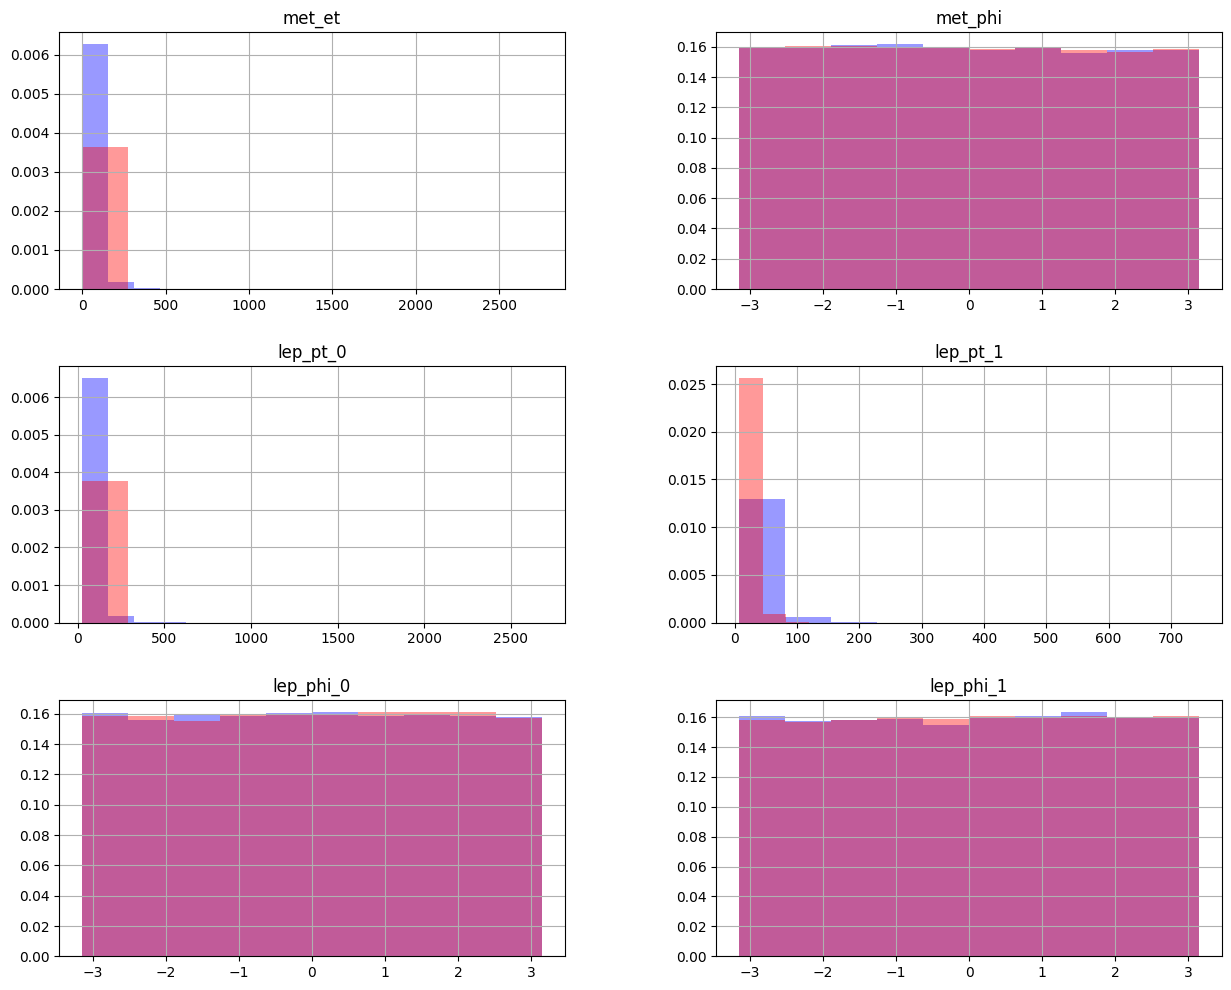

In [18]:
plt.figure()

ax=data[target==0].hist(weights=weights[target==0],figsize=(15,12),color='b',alpha=0.4,density=True)
ax=ax.flatten()[:data.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
data[target==1].hist(weights=weights[target==1],figsize=(15,12),color='r',alpha=0.4,density=True,ax=ax)

plt.show()

## Data splitting

It is very common in machine learning to split data into multiple independent sets, and only use part of the data for training/optimizing the machine learning models, and the rest for testing/evaluating performance.

In the following, we will split the whole data into training set, validation set and test set:

- __Training Dataset:__ The sample of data used to fit the model.
- __Validation Dataset:__ The sample used to provide an unbiased evaluation of a model fit on the training dataset while tuning  hyperparameters.
- __Test Dataset:__ The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

### Split the Data into Training and Test

In [19]:
train_size = 0.75 # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(data, target, weights, train_size=train_size)

y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

print ("Xtrain Shape: ",X_train.shape)
print ("ytrain Shape: ",y_train.shape)
print ("Training Weights: ",weights_train.shape,"\n")
print ("Xtest Shape: ",X_test.shape)
print ("ytest Shape: ",y_test.shape)
print ("Test Weights: ",weights_test.shape)

Xtrain Shape:  (433017, 6)
ytrain Shape:  (433017,)
Training Weights:  (433017,) 

Xtest Shape:  (144340, 6)
ytest Shape:  (144340,)
Test Weights:  (144340,)


### Doing an extra data split. Test _and_ Validation

In [20]:
X_test, X_val, y_test, y_val, weights_test, weights_val, = \
    train_test_split(X_test, y_test, weights_test, train_size=0.5, shuffle=False)

print ("Xtrain Shape: ",X_train.shape)
print ("ytrain Shape: ",y_train.shape)
print ("Training Weights: ",weights_train.shape,"\n")
print ("Xval Shape: ",X_val.shape)
print ("yval Shape: ",y_val.shape)
print ("Validation Weights: ",weights_val.shape, "\n")
print ("Xtest Shape: ",X_test.shape)
print ("ytest Shape: ",y_test.shape)
print ("Test Weights: ",weights_test.shape)

Xtrain Shape:  (433017, 6)
ytrain Shape:  (433017,)
Training Weights:  (433017,) 

Xval Shape:  (72170, 6)
yval Shape:  (72170,)
Validation Weights:  (72170,) 

Xtest Shape:  (72170, 6)
ytest Shape:  (72170,)
Test Weights:  (72170,)


## Standardize the Data

When optimizing the node weights of a neural netowrk, the input scale can significantly affect the performance. That is, unscaled (raw) input variables can result in a slow or unstable learning process. We would therefore like to rescale input variables prior to training a neural network model.

There are 2 common ways to rescale the data:

1. **Scale to Mean of 0 and Variance of 1.0:**   $\ \ \ \ x^\prime = (x-\mu)/\sigma$
2. **Scale to Max of 1 and Min of 0:**   $\ \ \ \ x^\prime = (x-x_{\mathrm{min}})/(x-x_{\mathrm{max}})$''

In the following, we will go with the first approach, but feel free to try the second approach! (hint: use [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html))

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Adjust the Test and Train Signal/Background Weights
Train on equal amount of Signal and Background, Test on 'natural' ratio

In [22]:
class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())
print ("class_weights_train:", class_weights_train)
for i in range(len(class_weights_train)):
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] #equalize number of background and signal event

    weights_val[y_val == i] *= max(class_weights_train)/ class_weights_train[i] #likewise for validation and test sets
    weights_test[y_test == i] *= max(class_weights_train)/ class_weights_train[i] #likewise for validation and test sets
    
print ("Train : total weight sig", weights_train[y_train == 1].sum())
print ("Train : total weight bkg", weights_train[y_train == 0].sum())
print ("Validation : total weight sig", weights_val[y_val == 1].sum())
print ("Validation : total weight bkg", weights_val[y_val == 0].sum())
print ("Test : total weight sig", weights_test[y_test == 1].sum())
print ("Test : total weight bkg", weights_test[y_test == 0].sum())

class_weights_train: (119.31596003199998, 4.631542095999999)
Train : total weight sig 119.31596003200002
Train : total weight bkg 119.31596003199998
Validation : total weight sig 19.99033998298113
Validation : total weight bkg 20.1582099374
Test : total weight sig 19.88491951594989
Test : total weight bkg 20.214321930199997


## Training the neural network

In the following, we will use TensorFlow and Keras to build our neural network and train the model.

The architecture is pretty simple: 2 hidden layers with the ReLu activation function. The last layer uses the Sigmoid activation to output the classifier score ranging from 0 to 1.

We will use the binary cross-entropy as the loss function, and use the Adam optimizer to train the model.

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)), # input layer
    tf.keras.layers.Dense(128, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(128, activation='relu'), # 2nd hiddden layer
    tf.keras.layers.Dense(1,activation="sigmoid") # output layer
])

model.compile(loss="binary_crossentropy", optimizer="adam", weighted_metrics=[AUC(name="auc")
])

In [58]:
starting_time = time.time( )
print("Start training!")
the_fit = model.fit(X_train,
                    y_train.values,
                    sample_weight=weights_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_val, y_val, weights_val),
                    # callbacks=[K.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')], # uncomment to use early stopping (also increase the epochs)
                    )

training_time = time.time( ) - starting_time
print("Training time:",training_time)

Start training!
Epoch 1/50
3383/3383 [==============================] - 13s 4ms/step - loss: 2.2818e-04 - auc: 0.8769 - val_loss: 2.3446e-04 - val_auc: 0.8726
Epoch 2/50
3383/3383 [==============================] - 3s 1ms/step - loss: 2.2797e-04 - auc: 0.8771 - val_loss: 2.3487e-04 - val_auc: 0.8714
Epoch 3/50
3383/3383 [==============================] - 4s 1ms/step - loss: 2.2791e-04 - auc: 0.8774 - val_loss: 2.3584e-04 - val_auc: 0.8718
Epoch 4/50
3383/3383 [==============================] - 3s 994us/step - loss: 2.2777e-04 - auc: 0.8774 - val_loss: 2.3396e-04 - val_auc: 0.8733
Epoch 5/50
3383/3383 [==============================] - 3s 984us/step - loss: 2.2752e-04 - auc: 0.8776 - val_loss: 2.3443e-04 - val_auc: 0.8724
Epoch 6/50
3383/3383 [==============================] - 3s 998us/step - loss: 2.2758e-04 - auc: 0.8776 - val_loss: 2.3363e-04 - val_auc: 0.8732
Epoch 7/50
3383/3383 [==============================] - 3s 1ms/step - loss: 2.2761e-04 - auc: 0.8774 - val_loss: 2.3363e-04 -

### Plot the training progress

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


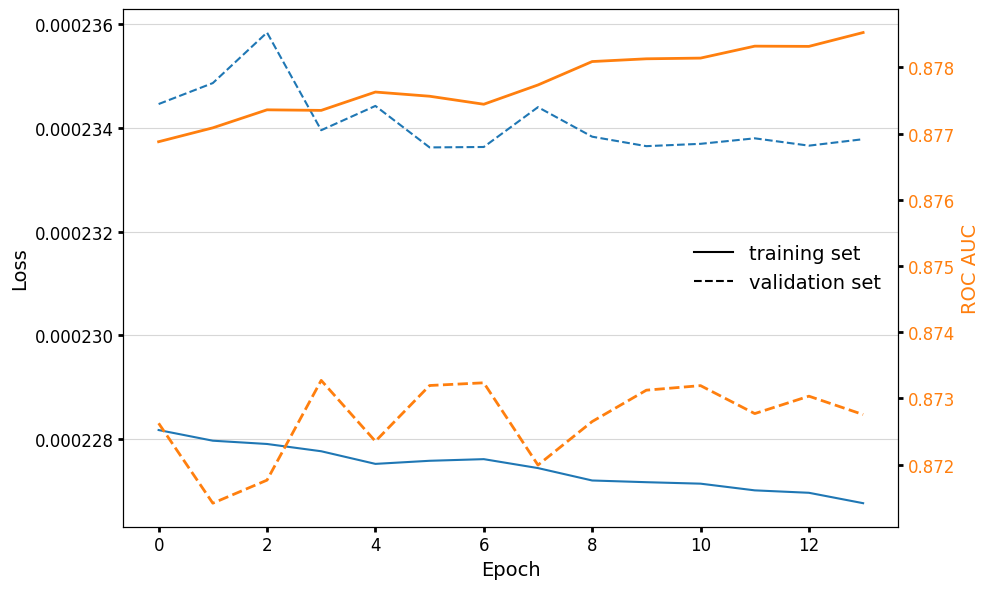

In [59]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(the_fit.history['loss'], color="tab:blue")
ax.plot(the_fit.history['val_loss'], color="tab:blue", ls="--")
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=12)
ax.legend(fontsize=14, frameon=False, loc="upper right")
ax.grid(True, axis='y')

ax2 = ax.twinx()
ax2.set_ylabel("ROC AUC", color='tab:orange', fontsize=14)
ax2.tick_params(width=2, grid_alpha=0.5, labelsize=12, axis='y', labelcolor='tab:orange')
ax2.plot(the_fit.history['auc'], color='tab:orange', lw=2)
ax2.plot(the_fit.history['val_auc'], color='tab:orange', ls='--', lw=2)
# ax2.set_ylim([0, 1])

ax2.plot([], [], color="black", label="training set")
ax2.plot([], [], color="black", ls='--', label="validation set")
ax2.legend(fontsize=14, frameon=False, loc="right")
fig.tight_layout()

### Use the model to make predicions!
Evaluate the model based on predictions made with X_test $\rightarrow$ y_test

In [60]:
y_pred_test = model.predict(X_test).ravel()
y_pred_train = model.predict(X_train).ravel()

 112/2256 [>.............................] - ETA: 0s 

13532/13532 [==============================] - 5s 401us/step


### ROC curves and Area Under the Curve (AUC)

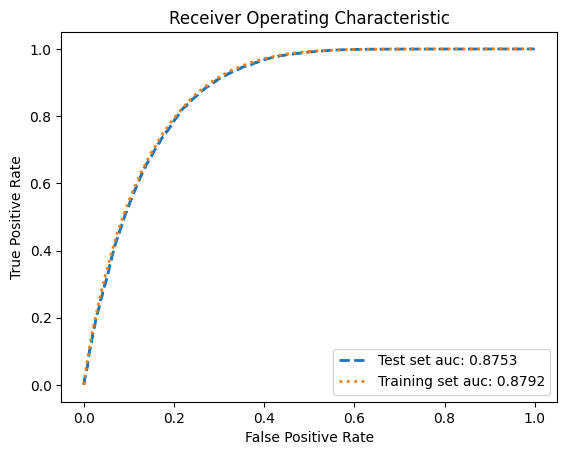

In [61]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=y_pred_test,sample_weight=weights_test)
fpr_train, tpr_train, _ = roc_curve(y_true=y_train, y_score=y_pred_train,sample_weight=weights_train)
auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_test,sample_weight=weights_test)
auc_train = roc_auc_score(y_true=y_train.values, y_score=y_pred_train,sample_weight=weights_train)
plt.plot(fpr_test, tpr_test, color='tab:blue',lw=2, ls="--", label=f"Test set auc: {auc_test:.4f}")
plt.plot(fpr_train, tpr_train, color='tab:orange',lw=2, ls=":", label=f"Training set auc: {auc_train:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Plotting NN Score for Signal and Background

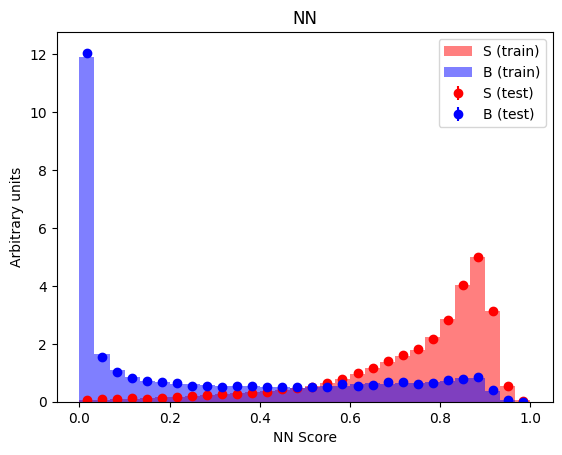

In [62]:
from extra_functions import compare_train_test
compare_train_test(y_pred_train, y_train, y_pred_test, y_test, 
                   xlabel="NN Score", title="NN", 
                   weights_train=weights_train.values, weights_test=weights_test.values)

## Significance Function

$\mathrm{med}[Z_0|1] = \sqrt{q_{0,A}} = \sqrt{2+((s+b)\ln(1+s/b)-s)}$

**asimov significance [arXiv:1007.1727](https://arxiv.org/pdf/1007.1727.pdf) [Eq. 97]**

Likelihood-based statistical test for significance. Need to esimate your sensitivity to MC. Running a toy MC thousands of times, should converge to 'truth'. Asimov is representative of number of sigmas in the gaus case.

Essentially: For an observed number of signal events $s$, what is the significance $Z_0$ with which we would reject the $s = 0$ hypothesis

In [63]:
from math import sqrt
from math import log
def amsasimov(s,b):
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)

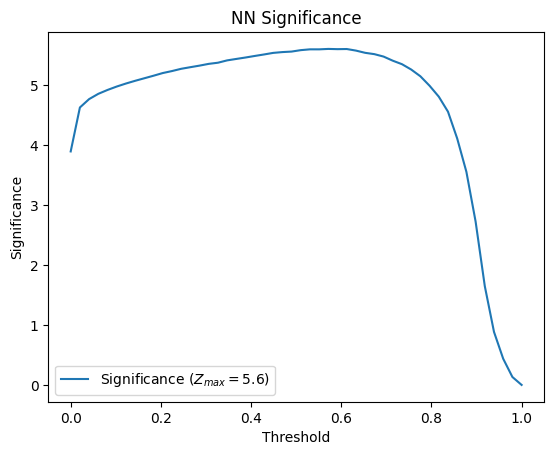

In [64]:
int_pred_test_sig = [weights_test[(y_test ==1) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg = [weights_test[(y_test ==0) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
vamsasimov = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig,int_pred_test_bkg)]
Z = max(vamsasimov)

plt.plot(np.linspace(0,1,num=50),vamsasimov, label=f'Significance ($Z_{{max}} = {np.round(Z,decimals=2)}$)')
plt.title("NN Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
plt.show()

## What does overtraining look like?

Recipe:
1. Add More layers
2. Add more nodes per layer
3. Train on less data

In [48]:
#Crazy Example
N = len(X_train)
n = int(N/1000)
print("Using",n,"/",N, "events")

X_small = X_train[:n]
y_small = y_train[:n]
weights_small = weights_train[:n]

Using 433 / 433017 events


In [49]:
ot_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_small.shape[1],)), # input layer
    tf.keras.layers.Dense(256, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
ot_model.compile(loss="binary_crossentropy", optimizer="adam", weighted_metrics=[AUC(name="auc")])
starting_time = time.time( )

the_overfit = ot_model.fit(X_small,
                    y_small.values,
                    sample_weight=weights_small,
                    epochs=25,
                    batch_size=128,
                    validation_data=(X_val, y_val, weights_val)
                    )

training_time = time.time( ) - starting_time
print("Training time:",training_time)

Epoch 1/25


4/4 [==============================] - 12s 4s/step - loss: 3.7171e-04 - auc: 0.5507 - val_loss: 3.7725e-04 - val_auc: 0.7169
Epoch 2/25
4/4 [==============================] - 1s 179ms/step - loss: 3.6043e-04 - auc: 0.7602 - val_loss: 3.6800e-04 - val_auc: 0.7540
Epoch 3/25
4/4 [==============================] - 1s 179ms/step - loss: 3.4961e-04 - auc: 0.7841 - val_loss: 3.5959e-04 - val_auc: 0.7569
Epoch 4/25
4/4 [==============================] - 1s 184ms/step - loss: 3.3724e-04 - auc: 0.8019 - val_loss: 3.5115e-04 - val_auc: 0.7570
Epoch 5/25
4/4 [==============================] - 1s 177ms/step - loss: 3.2530e-04 - auc: 0.8044 - val_loss: 3.4226e-04 - val_auc: 0.7568
Epoch 6/25
4/4 [==============================] - 1s 184ms/step - loss: 3.1376e-04 - auc: 0.8033 - val_loss: 3.3380e-04 - val_auc: 0.7592
Epoch 7/25
4/4 [==============================] - 1s 175ms/step - loss: 3.0348e-04 - auc: 0.8028 - val_loss: 3.2863e-04 - val_auc: 0.7600
Epoch 8/25
4/4 [==============================]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


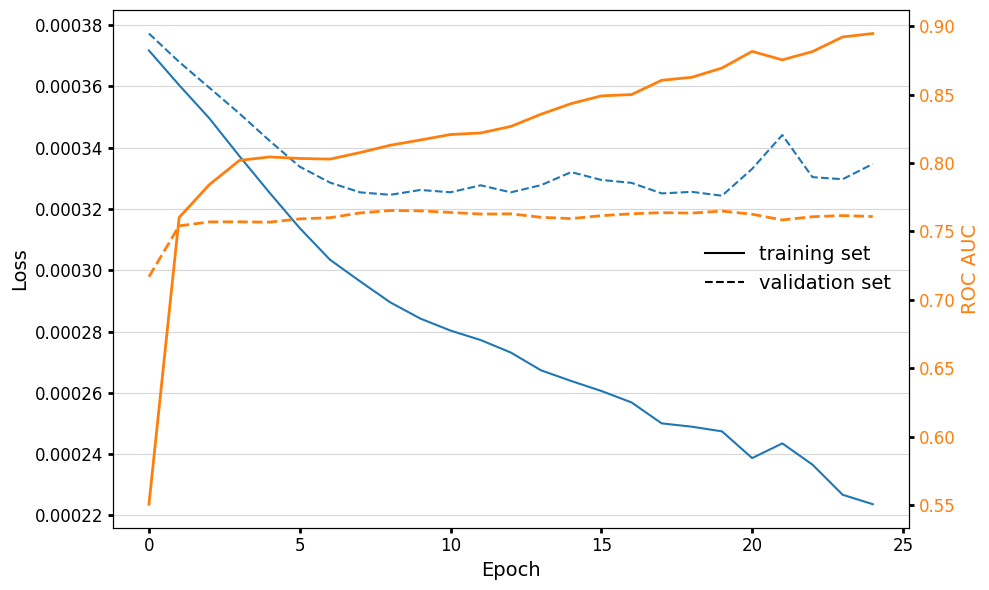

In [50]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(the_overfit.history['loss'], color="tab:blue")
ax.plot(the_overfit.history['val_loss'], color="tab:blue", ls="--")
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=12)
ax.legend(fontsize=14, frameon=False, loc="upper right")
ax.grid(True, axis='y')

ax2 = ax.twinx()
ax2.set_ylabel("ROC AUC", color='tab:orange', fontsize=14)
ax2.tick_params(width=2, grid_alpha=0.5, labelsize=12, axis='y', labelcolor='tab:orange')
ax2.plot(the_overfit.history['auc'], color='tab:orange', lw=2)
ax2.plot(the_overfit.history['val_auc'], color='tab:orange', ls='--', lw=2)
# ax2.set_ylim([0, 1])

ax2.plot([], [], color="black", label="training set")
ax2.plot([], [], color="black", ls='--', label="validation set")
ax2.legend(fontsize=14, frameon=False, loc="right")
fig.tight_layout()

In [51]:
ot_y_pred_test = ot_model.predict(X_test).ravel()
ot_y_pred_train = ot_model.predict(X_small).ravel()

   1/2256 [..............................] - ETA: 1:36

14/14 [==============================] - 0s 672us/step


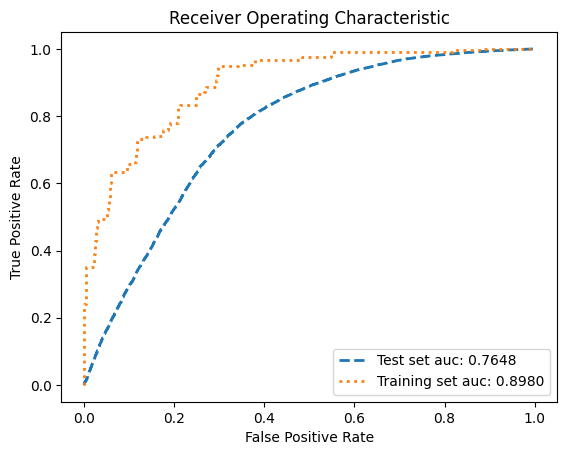

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=ot_y_pred_test,sample_weight=weights_test)
fpr_train, tpr_train, _ = roc_curve(y_true=y_small, y_score=ot_y_pred_train,sample_weight=weights_small)
auc_test = roc_auc_score(y_true=y_test, y_score=ot_y_pred_test,sample_weight=weights_test)
auc_train = roc_auc_score(y_true=y_small.values, y_score=ot_y_pred_train,sample_weight=weights_small)
plt.plot(fpr_test, tpr_test, color='tab:blue',lw=2, ls="--", label=f"Test set auc: {auc_test:.4f}")
plt.plot(fpr_train, tpr_train, color='tab:orange',lw=2, ls=":", label=f"Training set auc: {auc_train:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Exercises

1.   Improve NN AUC and significance by increasing the number of neurons, and layers, epochs, or by any other techniques (google) 
        - (beware of training time)
        - Explore!
        - Loss: [BCE, MSE,]
        - Batch size
        - Early stopping
        - Activations: [relu, leakyrelu, selu, tanh]
2.   Add more features and engineer aditional Features      
3.   What happens when we don't standardize our inputs? What about a different prescaling (using [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for example?)
4.   What happens when we don't use balanced weights for signal and background? 
___




